***fetched rows
     year number_of_movies
0  1874.0                1
1  1878.0                1
2  1883.0                1
3  1887.0                1
4  1888.0                2


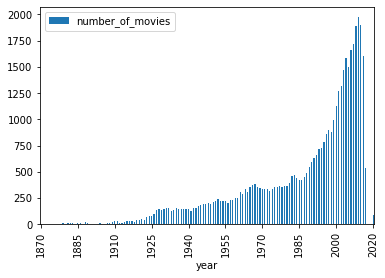

In [1]:
import psycopg2
import config
import psycopg2.extras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
DB_HOST='adb21.postgres.database.azure.com'
DB_USER='con1@adb21'
DB_PASSWORD='con1'
DB_NAME='postgres'

connection=psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD)

def postgresToDf(connection,query,column_names):
    cursor=connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cursor.execute(query)
    rows=cursor.fetchall()
    print("***fetched rows")
    cursor.close()

    df=pd.DataFrame(np.array(rows),columns=column_names)
    print(df.head())
    return df

col_names=["year","number_of_movies"]
query="""
   select extract(year from release_date) as year, count(*) as number_of_movies
   from project.movies_metadata
   group by year
   order by year;
    """
df=postgresToDf(connection,query,col_names)
ax=df.plot.bar(x='year')
plt.xticks([0, 15, 30, 45,60,75,90,105,120,135],
           ['1870', '1885','1910','1925','1940','1955','1970','1985','2000','2020'])
plt.show()






***fetched rows
       genre number_of_movies
0  Adventure             3490
1    Fantasy             2309
2  Animation             1931
3      Drama            20244
4     Horror             4671


<AxesSubplot:xlabel='genre', ylabel='number_of_movies'>

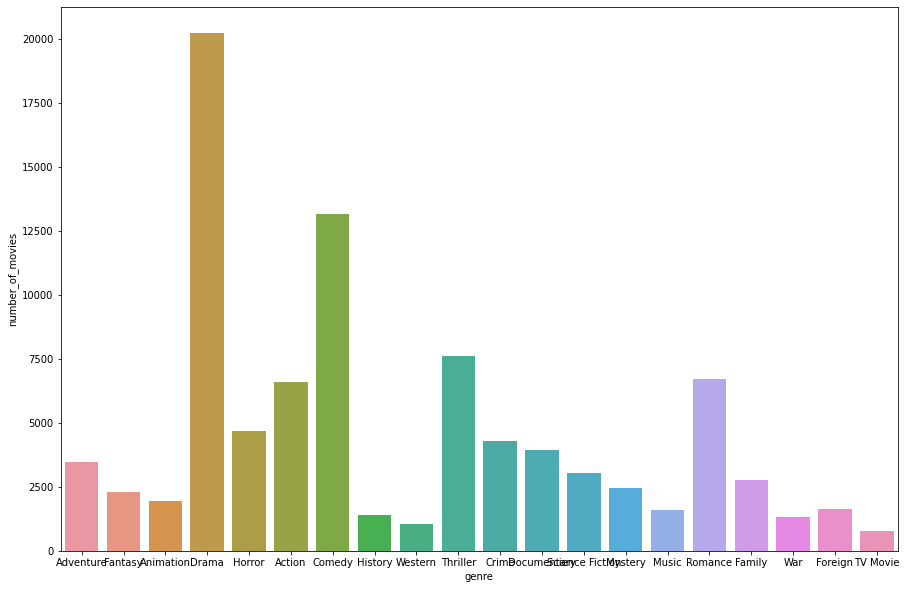

In [2]:
#Second Plot

col_names=["genre","number_of_movies"]
query="""
   select genre ->>'name' "name", count(*)
from project.movies_metadata
cross join jsonb_array_elements(genres) genre
GROUP BY genre;
    """
df=postgresToDf(connection,query,col_names)
df['number_of_movies'] = df['number_of_movies'].astype(str).astype(int)
#ax=df.plot.bar(x='genre', y='number_of_movies')
plt.figure(figsize=(15,10))
sns.barplot( data = df,x='genre', y='number_of_movies')

***fetched rows
     year            genre count
0  2020.0  Science Fiction     1
1  2020.0           Action     1
2  2020.0        Adventure     1
3  2020.0          Fantasy     1
4  2018.0            Drama     3


<AxesSubplot:xlabel='genre', ylabel='count'>

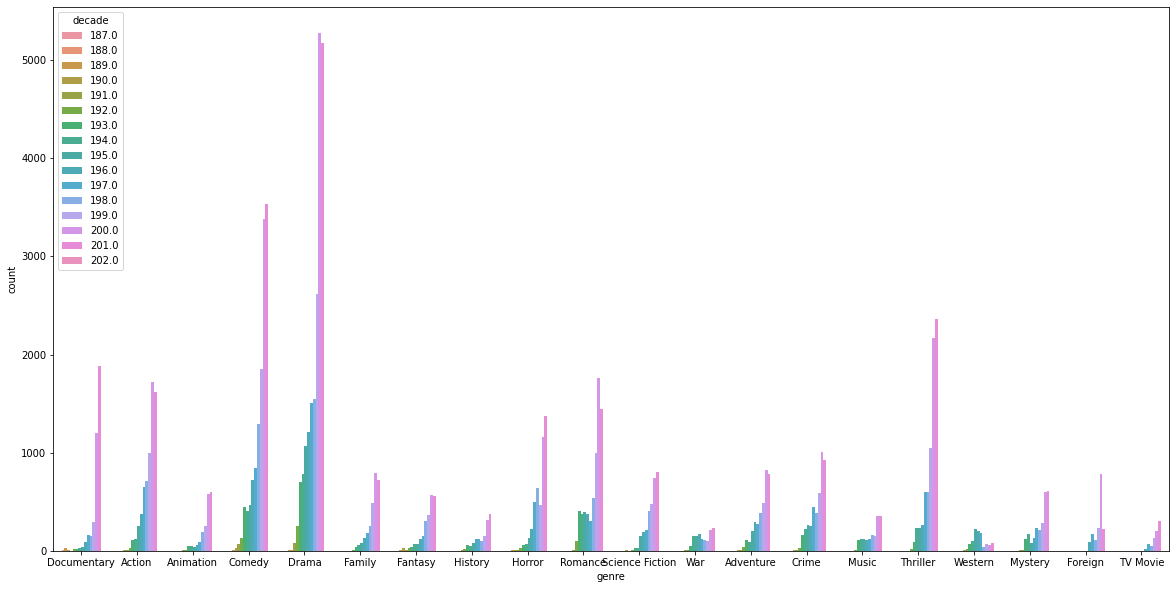

In [3]:
##Third 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


col_names=["year","genre","count"]
query="""
   select extract(year from release_date) as year, genre ->>'name' "name" , count(genre)
from project.movies_metadata
cross join jsonb_array_elements(genres) genre
where extract(year from release_date) is not NULL
group by genre, year
order by year desc, count(distinct genre);
    """
df=postgresToDf(connection,query,col_names)
#df['count'].value_counts()
#df['count'][371]
#df.iloc[50:54]
df['decade'] =((df['year'].astype(str).astype(float))/10).apply(np.floor)
df['count'] = df['count'].astype(str).astype(float)
Grouped = df.groupby(['genre','decade']).size().reset_index().rename(columns={0:'Sum of Releases'})
data = df.groupby(['decade','genre'], as_index=False)['count'].sum()
plt.figure(figsize=(20,10))
sns.barplot( data = data, x = "genre", y = "count", hue= "decade")

***fetched rows
       genre avg_rating
0  Adventure       5.69
1    Fantasy       5.79
2  Animation       6.28
3      Drama       5.91
4     Horror       5.23


<AxesSubplot:xlabel='genre', ylabel='avg_rating'>

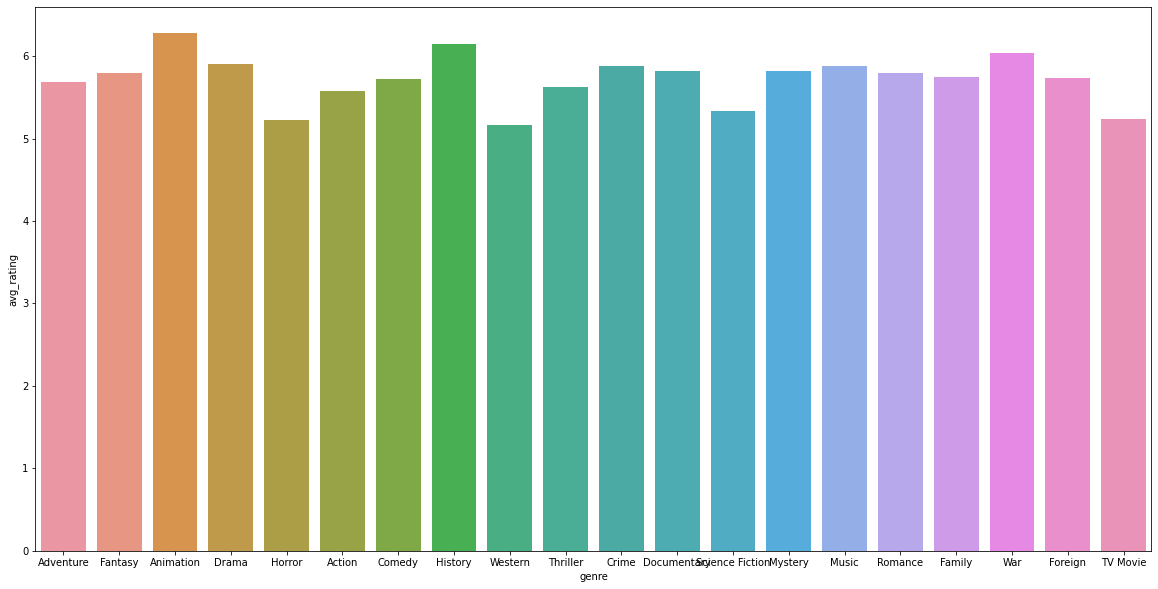

In [4]:
#fourthplot avg rating per genre
col_names=["genre","avg_rating"]
query="""
   select genre ->> 'name' "name", round(avg(vote_average), 2) "average"
from project.movies_metadata
cross join jsonb_array_elements(genres) genre
group by genre
order by genre;
    """
df=postgresToDf(connection,query,col_names)
plt.figure(figsize=(20,10))
sns.barplot(data=df,x='genre',y='avg_rating',label="Average rating per genre")

***fetched rows
   userid  number_of_ratings
0       1                  6
1       2                 58
2       3                 25
3       4                114
4       5                 53


<AxesSubplot:xlabel='userid', ylabel='number_of_ratings'>

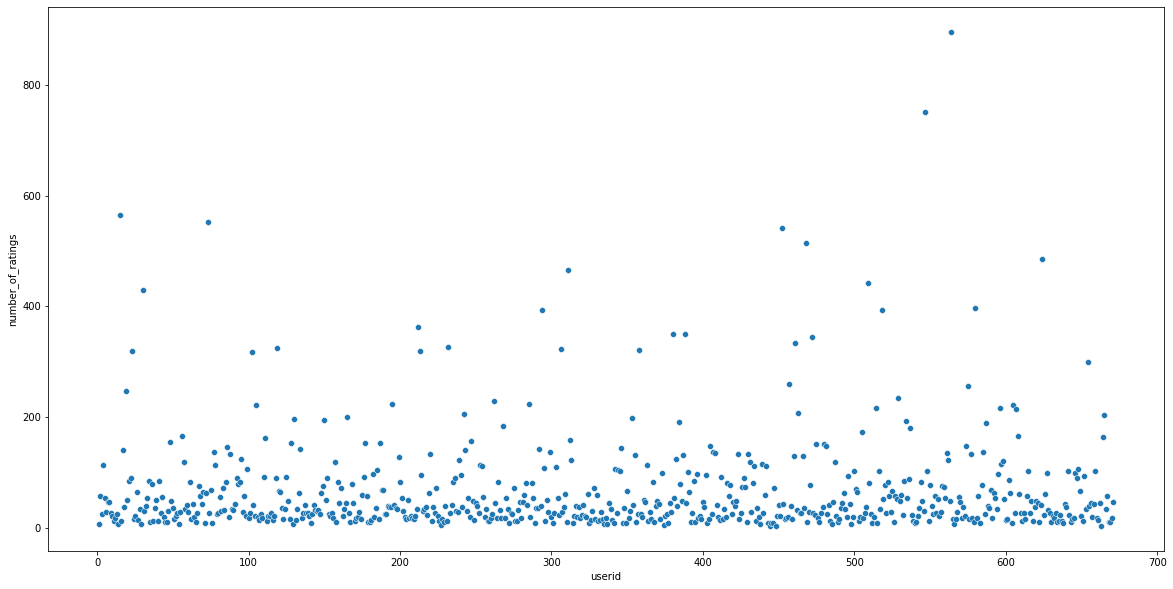

In [5]:
#fifth plot number of ratings per user
col_names=["userid","number_of_ratings"]
query="""
   select distinct userid , count(rating)
from project.ratings
group by userid
order by userid;
    """
df=postgresToDf(connection,query,col_names)
ratings_per_user=df
df.head
plt.figure(figsize=(20,10))
sns.scatterplot(data=df,x='userid', y='number_of_ratings')



***fetched rows
  userid avg_rating
0      1       2.33
1      2       3.52
2      3       3.54
3      4       4.27
4      5       3.92


<AxesSubplot:xlabel='userid', ylabel='avg_rating'>

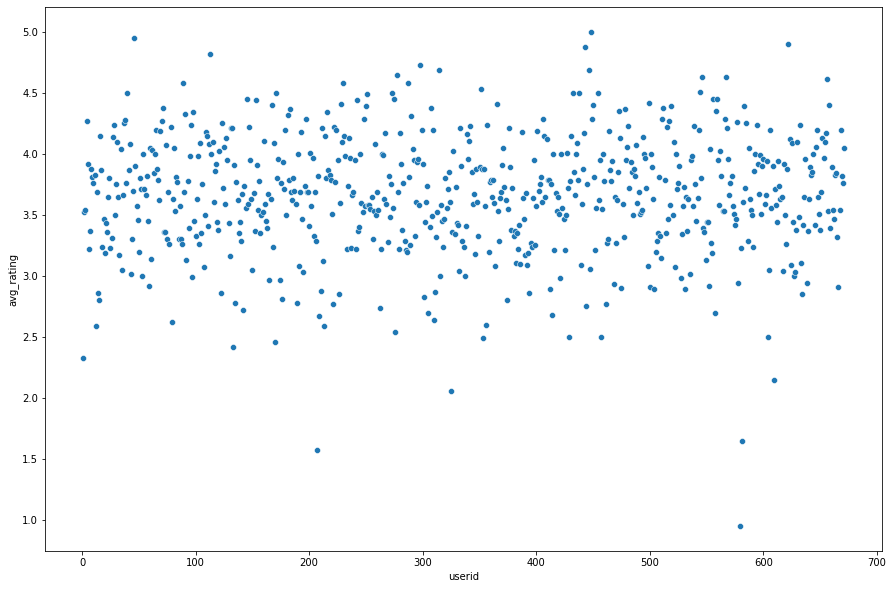

In [6]:
#sixth plot avg rating per user
col_names=["userid","avg_rating"]
query="""
   select distinct userid, round(avg(rating),2)
from project.ratings
group by userid
order by userid;
    """
avg_rating_per_user=postgresToDf(connection,query,col_names)
plt.figure(figsize=(15,10))
sns.scatterplot(data=avg_rating_per_user,x='userid', y='avg_rating')


<AxesSubplot:xlabel='number_of_ratings', ylabel='avg_rating'>

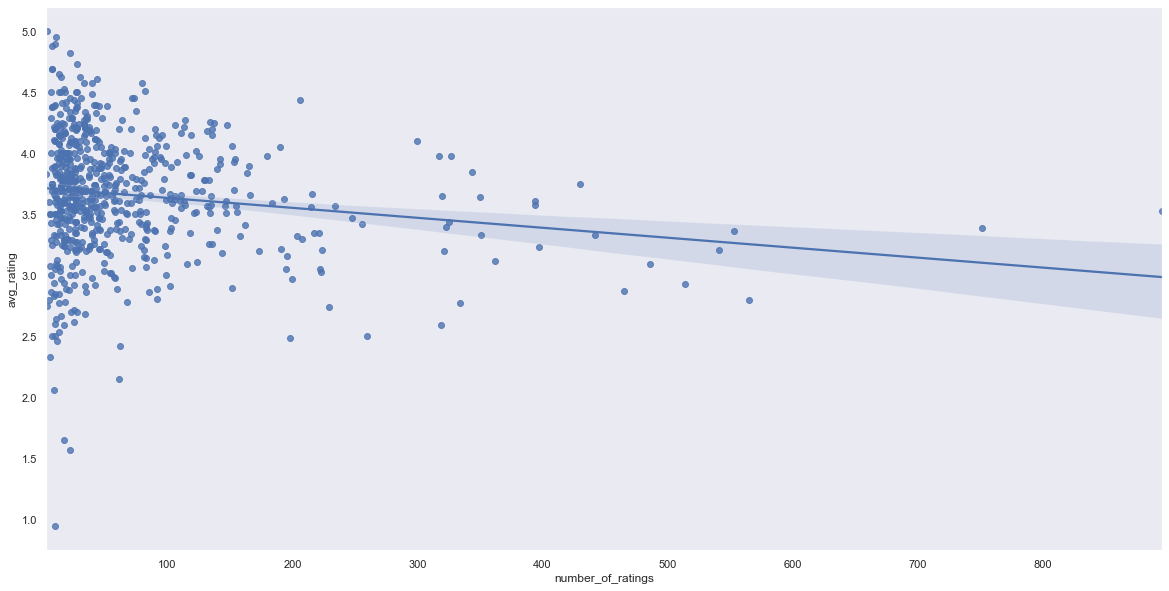

In [49]:
number_of_ratings=ratings_per_user["number_of_ratings"]
rating_combined=avg_rating_per_user.join(number_of_ratings)
rating_combined['avg_rating']=rating_combined['avg_rating'].astype(str).astype(float)
rating_combined['number_of_ratings']=rating_combined['number_of_ratings'].astype(str).astype(float)
rating_combined.head()

#sns.set_theme(style="dark")
#sns.scatterplot(data=rating_combined,y='avg_rating',x='number_of_ratings')
plt.figure(figsize=(20,10))
sns.regplot(data=rating_combined,x='number_of_ratings',y='avg_rating')
